In [1]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

from matplotlib.pyplot import loglog 

%matplotlib inline 


In [2]:
df = pd.read_csv('/home/merchantsameer2014/project/dnc-temporalGraph/out.dnc-temporalGraph', sep='\t', header=None)

In [3]:
df.head(2)

,0,1,2,3
0,419,465,1,1463507482
1,869,453,1,1462337903


In [4]:
df.columns = ['src', 'dst', 'weight', 'timestamp']

In [5]:
df.head(2)

,src,dst,weight,timestamp
0,419,465,1,1463507482
1,869,453,1,1462337903


In [6]:
def ProcessEdgeRow(row, Graph):
    src = row['src']
    dst = row['dst']
    timestamp = row['timestamp']
    
    if not Graph.IsNode(src):
        Graph.AddNode(src)
    
    if not Graph.IsNode(dst):
        Graph.AddNode(dst)
        
    if not Graph.IsEdge(src, dst):
        EId = Graph.AddEdge(src, dst)   
    else:
        EId = Graph.GetEI(src, dst) 
    
    Graph.AddIntAttrDatE(EId, timestamp, 'timestamp')
        
    return
        

In [7]:
def GenerateDirectedGraph(df):
    '''
    Returns a TNEANet Graph object 
    '''
    Graph = snap.TNEANet.New()
    df.apply(ProcessEdgeRow, axis=1, Graph=Graph)

    return Graph

In [8]:
G = GenerateDirectedGraph(df)

In [9]:
print "Nodes: ", G.GetNodes()
print "Edges: ", G.GetEdges()

Nodes:  1891
Edges:  5598


## Get Raw Statistics 

    1. Degree Centrality 
    2. Clustering Coefficient 
    3. Mean shortest path from each node 
    4. Betweeness Centralitily 
    5. Hub and Authority Score 

In [41]:
NodeAttributes = dict()

#### Step 1: Degree Centrality

In [42]:
#
# 1. Degree Centrality 
#    Get In Degree and Out Degree for each node 
#
InDegV = snap.TIntPrV()
OutDegV = snap.TIntPrV()

snap.GetNodeOutDegV(G, OutDegV)
snap.GetNodeInDegV(G, InDegV)

InDegreeList = [ (item.GetVal1(), item.GetVal2()) for item in InDegV ]
OutDegreeList = [ (item.GetVal1(), item.GetVal2()) for item in OutDegV ]

In [43]:
InDegreeList.sort(key=lambda x: x[1], reverse=True)
OutDegreeList.sort(key=lambda x: x[1], reverse=True)

minOutDegree = min(OutDegreeList, key = lambda x: x[1])[1]
maxOutDegree = max(OutDegreeList, key = lambda x: x[1])[1]
minInDegree = min(InDegreeList, key = lambda x: x[1])[1]
maxInDegree = max(InDegreeList, key = lambda x: x[1])[1]

In [44]:
#
# Sanity Check 
print maxOutDegree, minOutDegree, maxInDegree, minInDegree
print InDegreeList[0], InDegreeList[-1]

331 0 249 0
(1874, 249) (893, 0)


In [45]:
for (nodeId, Degree) in InDegreeList:
    if not NodeAttributes.get(nodeId, None):
        NodeAttributes[nodeId] = dict()
    NodeAttributes[nodeId]['InDegree'] = Degree
    normalizedDegree = (float(Degree) - float(minInDegree))/(float(maxInDegree - float(minInDegree)))
    NodeAttributes[nodeId]['NormInDegree'] = normalizedDegree

for (nodeId, Degree) in OutDegreeList: 
    NodeAttributes[nodeId]['OutDegree'] = Degree
    normalizedDegree = (float(Degree) - float(minOutDegree))/(float(maxOutDegree - float(minOutDegree)))
    NodeAttributes[nodeId]['NormOutDegree'] = normalizedDegree

In [47]:
#
# Sanity Check 
#
print NodeAttributes[1874]
print NodeAttributes[893]

{'InDegree': 249, 'NormInDegree': 1.0, 'NormOutDegree': 1.0, 'OutDegree': 331}
{'InDegree': 0, 'NormInDegree': 0.0, 'NormOutDegree': 0.0030211480362537764, 'OutDegree': 1}


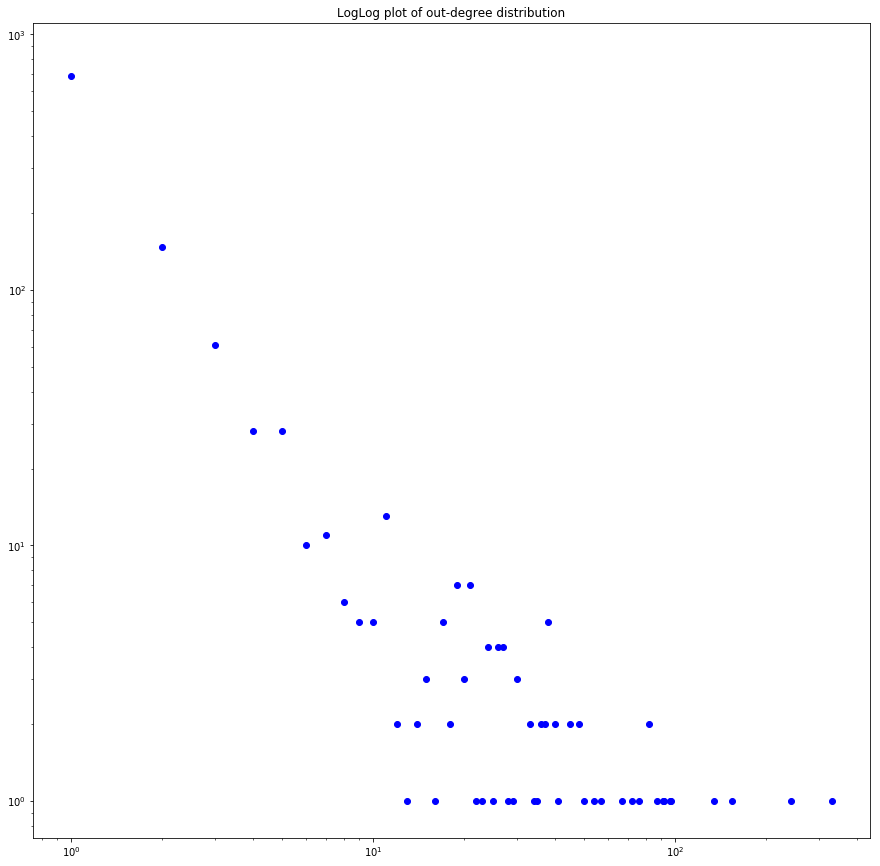

In [48]:

#
# Get Degree Distribution 
# 
OutDegToCntV = snap.TIntPrV()
snap.GetOutDegCnt(G, OutDegToCntV)
count = 0
nodeList = []
degreeList = []
for item in OutDegToCntV:
    (n, d) = (item.GetVal2(), item.GetVal1())
    nodeList.append(n)
    degreeList.append(d)
x = np.array( [ np.log10(item.GetVal1()) for itemm in OutDegToCntV if item.GetVal1() > 0 ] )
y = np.array( [ np.log10(item.GetVal2()) for item in OutDegToCntV if item.GetVal2() > 0 ] )
#
# Plot Degree Distribution
#
plt.figure(figsize=(15,15))
loglog(degreeList, nodeList, 'bo')
#plt.plot(x_plot, 10**b*x_plot**a, 'r-')
plt.title("LogLog plot of out-degree distribution")
plt.show()

#### Step 2: Clustering Coefficient

In [49]:
NIdCCfH = snap.TIntFltH()
snap.GetNodeClustCf(G, NIdCCfH)
ClusterCoeffList = list()
for nodeId in NIdCCfH:
    NodeAttributes[nodeId]['ClusterCoeff'] = NIdCCfH[nodeId]
    ClusterCoeffList.append((nodeId, NIdCCfH[nodeId]))

In [50]:
ClusterCoeffList.sort(key=lambda x: x[1], reverse=True)
minClusterCoeff = min(ClusterCoeffList, key=lambda x: x[1])[1]
maxClusterCoeff = max(ClusterCoeffList, key=lambda x: x[1])[1]

In [51]:
#
# Sanity Check 
#
print ClusterCoeffList[1], maxClusterCoeff, ClusterCoeffList[-1], minClusterCoeff

(1753, 1.0) 1.0 (1381, 0.0) 0.0


In [52]:
NIdCCfH = snap.TIntFltH()
snap.GetNodeClustCf(G, NIdCCfH)
ClusterCoeffList = list()
for nodeId in NIdCCfH:
    clusterCoeff = NIdCCfH[nodeId]
    normClusterCoeff = (clusterCoeff - minClusterCoeff)/(maxClusterCoeff - minClusterCoeff)
    NodeAttributes[nodeId]['NormClusterCoeff'] = normClusterCoeff

In [54]:
print NodeAttributes[2012]

{'NormOutDegree': 0.0, 'ClusterCoeff': 0.6666666666666666, 'InDegree': 3, 'OutDegree': 0, 'NormInDegree': 0.012048192771084338, 'NormClusterCoeff': 0.6666666666666666}


#### Step 3: Avergate shortest path length

In [57]:
nodeCount = float(G.GetNodes() - 1)
avgShortPathLenList = list()
for src in G.Nodes():
    srcId = src.GetId()
    totalShortPathLength = 0 
    
    for dst in G.Nodes():
        dstId = dst.GetId()
        #
        # Skip Self Edges
        #
        if srcId == dstId:
            continue
            
        #
        # Compute Shortest Path 
        #
        l = snap.GetShortPath(G, srcId, dstId, True)
        
        #
        # Skip nodes that cannot be reached 
        #
        if l < 0:
            continue
            
        totalShortPathLength += float(l) 
    NodeAttributes[srcId]['AvgShortPathLen'] = totalShortPathLength/nodeCount
    avgShortPathLenList.append((srcId, totalShortPathLength/nodeCount))

In [58]:
minAvgShortPathLength = min(avgShortPathLenList, key=lambda x: x[1])[1]
maxAvgShortPathLength = max(avgShortPathLenList, key=lambda x: x[1])[1]

In [61]:
for (node, spLen) in avgShortPathLenList:
    normAvgShortPath = (spLen - minAvgShortPathLength)/(maxAvgShortPathLength - minAvgShortPathLength)
    NodeAttributes[node]['normAvgShortPathLen'] = normAvgShortPath

In [62]:
print NodeAttributes[480]

{'NormOutDegree': 0.0030211480362537764, 'ClusterCoeff': 0.3333333333333333, 'normAvgShortPathLen': 1.0, 'InDegree': 2, 'OutDegree': 1, 'NormInDegree': 0.008032128514056224, 'NormClusterCoeff': 0.3333333333333333, 'AvgShortPathLen': 4.321164021164021}


#### Step 4: Betweeness Centrality

In [64]:
Nodes = snap.TIntFltH()
Edges = snap.TIntPrFltH()
BetweenessNodeList = list()
BetweenessEdgeList = list()

snap.GetBetweennessCentr(G, Nodes, Edges, 1.0)
for node in Nodes:
    NodeAttributes[node]['Betweeness'] = Nodes[node]
    BetweenessNodeList.append((node, Nodes[node]))

for edge in Edges:
    #print "edge: (%d, %d) centrality: %f" % (edge.GetVal1(), edge.GetVal2(), Edges[edge])
    BetweenessEdgeList.append((edge.GetVal1(), edge.GetVal2(), Edges[edge]))

BetweenessNodeList.sort(key=lambda x: x[1], reverse=True) 
BetweenessEdgeList.sort(key=lambda x: x[2], reverse=True)

In [65]:
print BetweenessNodeList[0], BetweenessNodeList[-1]

(1669, 556845.3564806876) (884, 0.0)


In [66]:
minBetweeness = BetweenessNodeList[-1][1]
maxBetweeness = BetweenessNodeList[0][1]
for (node, betweeness) in BetweenessNodeList:
    normBetweeness = (betweeness - minBetweeness)/(maxBetweeness - minBetweeness)
    NodeAttributes[node]['normBetweeness'] = normBetweeness
    

In [68]:
print NodeAttributes[1669]
print NodeAttributes[884]

{'NormOutDegree': 0.7311178247734139, 'ClusterCoeff': 0.0007700181235972993, 'normAvgShortPathLen': 0.33304763070895066, 'InDegree': 222, 'normBetweeness': 1.0, 'OutDegree': 242, 'NormInDegree': 0.891566265060241, 'NormClusterCoeff': 0.0007700181235972993, 'Betweeness': 556845.3564806876, 'AvgShortPathLen': 1.439153439153439}
{'NormOutDegree': 0.0, 'ClusterCoeff': 0.0, 'normAvgShortPathLen': 0.0, 'InDegree': 1, 'normBetweeness': 0.0, 'OutDegree': 0, 'NormInDegree': 0.004016064257028112, 'NormClusterCoeff': 0.0, 'Betweeness': 0.0, 'AvgShortPathLen': 0.0}


#### Step 5: Get Auth and Hub Score

In [69]:
NIdHubH = snap.TIntFltH()
NIdAuthH = snap.TIntFltH()
snap.GetHits(G, NIdHubH, NIdAuthH)
HubNodes = []
for nodeId in  NIdHubH:
    HubNodes.append((nodeId,  NIdHubH[nodeId]))
    NodeAttributes[nodeId]['HubScore'] = NIdHubH[nodeId]
    
HubNodes.sort(key = lambda x: x[1], reverse=True)

AuthNodes = []
for nodeId in  NIdAuthH:
    AuthNodes.append((nodeId,  NIdAuthH[nodeId])) 
    NodeAttributes[nodeId]['AuthScore'] = NIdAuthH[nodeId]
AuthNodes.sort(key = lambda x: x[1], reverse=True)


In [70]:
print AuthNodes[0], AuthNodes[-1]
print HubNodes[0], HubNodes[-1]

(1874, 0.30510831720503034) (893, 0.0)
(1874, 0.38410704002084095) (884, 0.0)


In [71]:
minAuthNodes = AuthNodes[-1][1]
maxAuthNodes = AuthNodes[0][1]
minHubNodes = HubNodes[-1][1]
maxHubNodes = HubNodes[0][1]

In [72]:
for (node, hubScore) in HubNodes:
    normHubScore = (hubScore - minHubNodes)/(maxHubNodes - minHubNodes)
    NodeAttributes[node]['normHubScore'] = normHubScore
    
for (node, authScore) in AuthNodes:
    normAuthScore = (authScore - minAuthNodes)/(maxAuthNodes - minAuthNodes)
    NodeAttributes[node]['normAuthScore'] = normAuthScore

In [73]:
print NodeAttributes[1874]
print NodeAttributes[893]

{'NormOutDegree': 1.0, 'ClusterCoeff': 0.0014452513597956258, 'normAvgShortPathLen': 0.33696583812905595, 'InDegree': 249, 'normBetweeness': 0.8890896997683746, 'normAuthScore': 1.0, 'OutDegree': 331, 'AuthScore': 0.30510831720503034, 'NormInDegree': 1.0, 'normHubScore': 1.0, 'NormClusterCoeff': 0.0014452513597956258, 'HubScore': 0.38410704002084095, 'Betweeness': 495085.4708108281, 'AvgShortPathLen': 1.456084656084656}
{'NormOutDegree': 0.0030211480362537764, 'ClusterCoeff': 0.0, 'normAvgShortPathLen': 0.0001224439818782907, 'InDegree': 0, 'normBetweeness': 0.0, 'normAuthScore': 0.0, 'OutDegree': 1, 'AuthScore': 0.0, 'NormInDegree': 0.0, 'normHubScore': 0.00048173348087729835, 'NormClusterCoeff': 0.0, 'HubScore': 0.00018503722141871546, 'Betweeness': 0.0, 'AvgShortPathLen': 0.0005291005291005291}


## Automatic Social Hierarchy Detection From Email Network 

### Steps 

    1. Compute node's importance on response time for email  
    2. Get all Cliques (Algorithm 457)
    3. Number of clique each node is part of 
    4. Raw Clique Score computed using 
    
 $$R*2^{n-1}$$
 
    5. Weighted Clique Score (Based on importance of a person) 
    
 $$W = t*2^{n-1}$$
 

### Use networkx library for Clique analysis 

    1. Build a multigraph with edges for each (src, dst, timestamp) entry in the email data set 
    2. Build undirected graph with edges between nodes only when email count exceeds N=4 between two those nodes 
    

In [74]:
def ProcessNxEdgeRow(row, Graph):
    src = row['src']
    dst = row['dst']
    timestamp = row['timestamp']
    
    Graph.add_node(src)
    Graph.add_node(dst)
    Graph.add_edge(src, dst, timestamp=timestamp)
        
    return
        

In [75]:
def GenerateDirectedNxGraph(df):
    '''
    Returns a TNEANet Graph object 
    '''
    Graph = nx.MultiDiGraph(name="DNC Email Network")
    df.apply(ProcessNxEdgeRow, axis=1, Graph=Graph)

    return Graph

In [76]:
GNx = GenerateDirectedNxGraph(df)

In [77]:
print "Networkx Nodes: ", GNx.number_of_nodes()
print "Networkx Edges: ", GNx.number_of_edges()

Networkx Nodes:  1891
Networkx Edges:  39264


#### Prune all edges with N <=4 emails exchanged
As per the paper - consider edges between nodes only if the nodes have exchanged > N messages
N is a tunable parameter 

DNC email has a median of message exchanged = 2 

In [78]:
edgeCount = dict()
for edge in GNx.edges():
    if not edgeCount.get(edge, None):
        edgeCount[edge] = 0
    edgeCount[edge] += 1      

In [79]:
emailDist= [ v for k, v in edgeCount.iteritems() ]
emailDist.sort(reverse=True)

In [80]:
print emailDist[0], emailDist[-1], np.median(emailDist), len(emailDist)

731 1 2.0 5598


In [81]:
N = 4
pruneList = [ k for k, v in edgeCount.iteritems() if v <= N ]
prunedEdgeList = [ k for k, v in edgeCount.iteritems() if v > N ]

### Generate undirected graph with edges between nodes with email count > N

In [82]:
uGNx = nx.Graph()

for edge in prunedEdgeList:
    (src, dst) = edge
    uGNx.add_edge(src, dst)
    
print "Networkx Nodes: ", uGNx.number_of_nodes()
print "Networkx Edges: ", uGNx.number_of_edges() 

Networkx Nodes:  452
Networkx Edges:  1139


### Step 1: Compute Nodes importance on email response time 

### Approach 1: Based on Rowe et. al. paper 

Use response time to measure importance of a node 

    1. For each node get all the out bound email timestamps 
    2. For each email sent - check the response time from the receiver 
    3. Consider responses within a day for computing time score. 
    4. Consider response time for nodes that have exchanged at least 100 emails 
       (fewer emails with high response time can falsely promote node based on time score)
 

In [160]:
temporalMap = dict()
for n, nbrs in GNx.adjacency():
    temporalMap[n] = dict()
    for nbr, edict in nbrs.items():
        t1 = [d['timestamp'] for d in edict.values()]
        t1.sort()
        temporalMap[n][nbr] = t1 

In [197]:
avgNodeResponse = list()

for src, destinations in temporalMap.iteritems():
    totalRequestResp = 0
    totalResponseTime = 0.0
    
    for dst, reqTimestamps in destinations.iteritems():
        responseTime = None
        #
        # Walk through ALl requests sent to a destination
        #
        for req in reqTimestamps:
            reqTime = datetime.fromtimestamp(req)
        
            #
            # Look for response time from the destinaton to ths source
            #
            for resp in temporalMap[dst].get(src, list()):
                respTime = datetime.fromtimestamp(resp)
            
                if resp < req:
                    #
                    # Look for first response after the request time 
                    #
                    continue
            
                deltaTime = respTime - reqTime
            
                if deltaTime.total_seconds() > 86400:
                    #
                    # If response time exceeds a day don't 
                    # consider it as a response
                    break
                    
                #print "Found Response time: src: %d, dst: %d req: %s, resp: %s" % (src, dst, reqTime, respTime)
                
                totalRequestResp += 1
                totalResponseTime += deltaTime.total_seconds()
                break
    #
    # Compute average across all dst response times 
    #
    if totalRequestResp > 0 and totalResponseTime > 0:
        avgResponse = totalResponseTime/totalRequestResp
    else:
        #
        # Set default response to 7 day 
        #
        avgResponse = float(7*86400)
    #
    # Lower response Higher the timeScore 
    # 
    timeScore = 1/avgResponse
    avgNodeResponse.append((src, timeScore, totalResponseTime, totalRequestResp ))
        

In [213]:
avgNodeTimeScore = list()

#
# Ignore response time for email exchanges fewer than 10
#
for x in avgNodeResponse:
    (src, timeScore, totalResponseTime, totalRequestResp) = x
    
    if totalRequestResp <= 200:
        timeScore = 1.0/float(7*86400)
        
    avgNodeTimeScore.append((src, timeScore, totalResponseTime, totalRequestResp))
        
avgNodeTimeScore.sort(key=lambda x: x[1], reverse=True)


In [214]:
print avgNodeTimeScore[-1]
print avgNodeTimeScore[:2]

(2029, 1.6534391534391535e-06, 0.0, 0)
[(1625, 0.0020221266801294163, 368424.0, 745), (895, 0.00011885108532413246, 1918367.0, 228)]


In [215]:
print NodeAttributes[1625]

{'NormOutDegree': 0.030211480362537766, 'ClusterCoeff': 0.05714285714285714, 'normAvgShortPathLen': 0.4491245255295702, 'InDegree': 7, 'normBetweeness': 0.007319923714214854, 'normAuthScore': 0.12096933772423019, 'OutDegree': 10, 'AuthScore': 0.036908751066446865, 'NormInDegree': 0.028112449799196786, 'normHubScore': 0.09633108380044303, 'NormClusterCoeff': 0.05714285714285714, 'HubScore': 0.037001447460587755, 'Betweeness': 4076.0655300534095, 'AvgShortPathLen': 1.9407407407407407}


In [220]:
normTimeScore = dict()
minAvgTimeScore = avgNodeTimeScore[-1][1]
maxAvgTimeScore = avgNodeTimeScore[0][1]

for (node, timeScore, _, _) in avgNodeTimeScore:
    normTimeScore[node] = (timeScore - minAvgTimeScore)/(maxAvgTimeScore - minAvgTimeScore)

In [223]:
normTimeScore[1625]

1.0

In [232]:
nodeCliqueCount = dict()
rawCliqueScore = dict()
weightedCliqueScore = dict()

#
# Find all maximal cliques 
# 
for clique in nx.find_cliques(uGNx):
    for node in clique:
        
        if not nodeCliqueCount.get(node, None):
            nodeCliqueCount[node] = 0
            
        if not rawCliqueScore.get(node, None):
            rawCliqueScore[node] = 0
        
        if not weightedCliqueScore.get(node, None):
            weightedCliqueScore[node] = 0
            
        nodeCliqueCount[node] += 1 
        
        n = len(clique)
        
        rawCliqueScore[node] += 2**n
        
        weightedCliqueScore[node] += (2**n)*normTimeScore[node]

In [236]:
#
# Get a sorted list of nodes based on their clique count 
#
nodeCliqueList = [ (k, v) for k, v in nodeCliqueCount.iteritems() ]
nodeCliqueList.sort(key=lambda x: x[1], reverse=True )

In [237]:
rawCliqueList = [ (k, v) for k, v in rawCliqueScore.iteritems() ]
rawCliqueList.sort(key=lambda x: x[1], reverse=True )

In [238]:
weightedCliqueList = [ (k, v) for k, v in weightedCliqueScore.iteritems() ]
weightedCliqueList.sort(key=lambda x: x[1], reverse=True )

In [239]:
print nodeCliqueList[:10]
print rawCliqueList[:10]
print weightedCliqueList[:10]

[(1874, 157), (1839, 123), (1669, 104), (999, 79), (1258, 79), (1369, 76), (453, 75), (585, 66), (1144, 57), (1159, 46)]
[(1874, 29604), (999, 27636), (1258, 27616), (511, 22656), (1369, 21044), (1974, 18560), (1998, 18416), (585, 17972), (1144, 12248), (1899, 10304)]
[(1258, 1133.2113553681547), (1874, 1079.971912453243), (999, 887.6525051646298), (511, 671.973655462151), (1998, 455.752744276308), (585, 335.72489139325376), (1669, 246.35443082589936), (1440, 223.6014465859277), (1287, 134.0397246718862), (453, 98.89859633344226)]


In [242]:
minNodeCliqueCount = nodeCliqueList[-1][1]
maxNodeCliqueCount = nodeCliqueList[0][1]

minRawCliqueScore = rawCliqueList[-1][1]
maxRawCliqueScore = rawCliqueList[0][1]

minWeightedCliqueScore = weightedCliqueList[-1][1]
maxWeightedCliqueScore = weightedCliqueList[0][1]

In [243]:
for node, score in nodeCliqueList:
    NodeAttributes[node]['nodeClique'] = score
    NodeAttributes[node]['normNodeClique'] = float(score - minNodeCliqueCount)/float(maxNodeCliqueCount - minNodeCliqueCount)

In [245]:
for node, score in rawCliqueList:
    NodeAttributes[node]['rawClique'] = score
    NodeAttributes[node]['normRawClique'] = float(score - minRawCliqueScore)/float(maxRawCliqueScore - minRawCliqueScore)

In [247]:
for node, score in weightedCliqueList:
    NodeAttributes[node]['weigthedClique'] = score
    NodeAttributes[node]['normWeightedClique'] = float(score - minWeightedCliqueScore)/float(maxWeightedCliqueScore - minWeightedCliqueScore)

In [248]:
NodeAttributes[1874]

{'AuthScore': 0.30510831720503034,
 'AvgShortPathLen': 1.456084656084656,
 'Betweeness': 495085.4708108281,
 'ClusterCoeff': 0.0014452513597956258,
 'HubScore': 0.38410704002084095,
 'InDegree': 249,
 'NormClusterCoeff': 0.0014452513597956258,
 'NormInDegree': 1.0,
 'NormOutDegree': 1.0,
 'OutDegree': 331,
 'nodeClique': 157,
 'normAuthScore': 1.0,
 'normAvgShortPathLen': 0.33696583812905595,
 'normBetweeness': 0.8890896997683746,
 'normHubScore': 1.0,
 'normNodeClique': 1.0,
 'normRawClique': 1.0,
 'normWeightedClique': 0.9530189645005671,
 'rawClique': 29604,
 'weigthedClique': 1079.971912453243}

## Compute Weighted Social Score 

In [253]:
#
# Weights:
#
# W = [ Weighted Clique, RawClique, NumClique, OutDegree, InDegree, Cluster Coeff, Betweeness, Avg ShortPath, Auth, Hub]
#
w_weightedClique = 0.9
w_rawClique = 0.8
w_numClique = 0.7
w_outDegree = 0.6
w_inDegree = 0.6
w_clusterCoeff = 0.3 
w_betweeness = 0.3 
w_shortpath = 0.5 
w_auth = 0.2 
w_hub = 0.1 

w = np.array([w_weightedClique,\
             w_rawClique, \
             w_numClique, \
             w_outDegree, \
             w_inDegree, \
             w_clusterCoeff, \
             w_betweeness, \
             w_shortpath, \
             w_auth, \
             w_hub])

w_sum = np.sum(w)

### Social Score is computed as follows 

\begin{align}
w_x * C_x & = w_x * 100 * \left[ \frac{x_i - infx}{sup\ x - inf\ x} \right] \\
\\
score & = \frac{\Sigma_{all\ x} w * C_x}{\Sigma_{all\ x} w}
\end{align}

In [255]:
socialScore = list()

for node, attributes in NodeAttributes.iteritems():
    weightedClique = attributes.get('normWeightedClique', 0.0)
    rawClique = attributes.get('normRawClique', 0.0)
    numClique = attributes.get('normNodeClique', 0.0)
    outDeg =  attributes.get('NormOutDegree', 0.0)
    inDeg =  attributes.get('NormInDegree', 0.0)
    clusterCoeff =  attributes.get('NormClusterCoeff', 0.0)
    betweeness = attributes.get('normBetweeness', 0.0)
    shortestPath = attributes.get('normAvgShortPathLen', 0.0)
    authScore = attributes.get('normAuthScore', 0.0)
    hubSccore = attributes.get('normHubScore', 0.0)
    
    C_x = np.array([weightedClique, \
                   rawClique, \
                   numClique, \
                   outDeg, \
                   inDeg, \
                   clusterCoeff, \
                   betweeness, \
                   shortestPath, \
                   authScore, \
                   hubSccore])
    
    score = 100.0 * np.dot(w, C_x)/w_sum
    socialScore.append((node, score))
    

In [256]:
socialScore.sort(key=lambda x: x[1], reverse=True)

In [257]:
print socialScore[:10]

[(1874, 85.86720944906979), (1258, 55.9778907924103), (999, 50.61051396942534), (1669, 47.27542700847994), (511, 40.31705218340864), (585, 33.064089627423826), (1998, 32.41884981873541), (1839, 28.873591736745578), (1369, 28.7430390082418), (453, 28.201871267917863)]


In [260]:
with open('socialScore.txt', 'w') as fd:
    for (node, score) in socialScore:
        fd.write("%r  %r\n" % (node, score))